In [1]:
from langgraph.graph import StateGraph, START, END
from typing import Optional
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI()

In [4]:
class BlogState(BaseModel):

    topic: str = Field(..., description="The topic of the blog")
    outline: Optional[str] = Field(None, description="The outline of the blog")
    blog: Optional[str] = Field(None, description="The blog content")

In [5]:
def get_outline(state: BlogState) -> BlogState:
    topic = state.topic
    parser = StrOutputParser()
    prompt = PromptTemplate(
        template="Generate an outline for a Blog on the topic: {topic}",
        input_variables=['topic']
    )
    chain = prompt | model | parser
    outline = chain.invoke({'topic': topic})
    state.outline = outline
    return state

In [6]:
def get_blog(state: BlogState) -> BlogState:
    topic = state.topic
    outline = state.outline

    parser = StrOutputParser()
    prompt = PromptTemplate(
        template="""
        Generate a Blog on the topic:
        {topic}
        With this outline:
        {outline}
        """,
        input_variables=['topic', 'outline']
    )
    chain = prompt | model | parser

    blog = chain.invoke({'topic': topic, 'outline': outline})
    state.blog = blog
    return state

In [7]:
graph = StateGraph(BlogState)

graph.add_node("get_outline", get_outline)
graph.add_node("get_blog", get_blog)

graph.add_edge(START, "get_outline")
graph.add_edge("get_outline", "get_blog")
graph.add_edge("get_blog", END)

workflow = graph.compile()

In [8]:
initial_state = {"topic": "Cricket"}
final_state = workflow.invoke(initial_state)
final_state

{'topic': 'Cricket',
 'outline': "I. Introduction\n    A. Brief explanation of cricket\n    B. Popularity of cricket around the world\n\nII. History of Cricket\n    A. Origins of the sport\n    B. Evolution of the rules and regulations\n    C. Major milestones in cricket history\n\nIII. Formats of Cricket\n    A. Test cricket\n    B. One Day Internationals (ODIs)\n    C. Twenty20 (T20) cricket\n    D. Other variations of the game\n\nIV. Major Tournaments and Events\n    A. ICC Cricket World Cup\n    B. ICC T20 World Cup\n    C. The Ashes\n    D. Indian Premier League (IPL)\n    \nV. Famous Players\n    A. Legends of the game\n    B. Current top players\n    C. Women's cricket stars\n\nVI. Impact and Influence of Cricket\n    A. Economic impact of cricket\n    B. Social impact of cricket\n    C. Cultural significance of the sport\n\nVII. Challenges and Controversies in Cricket\n    A. Match-fixing scandals\n    B. Player disputes and controversies\n    C. Issues with governance and admi

In [9]:
print(final_state['blog'])

Cricket is a sport that has captured the hearts of millions around the world, with its unique combination of skill, strategy, and tradition. In this blog, we will explore the rich history, various formats, major tournaments, famous players, impact and influence, challenges and controversies, and the future of cricket.

I. Introduction
Cricket is a bat-and-ball game played between two teams on a large oval field. It originated in England and has since spread to become one of the most popular sports globally, especially in countries like India, Australia, and the Caribbean.

II. History of Cricket
Cricket has a long and storied history, dating back to the 16th century. The rules and regulations of the game have evolved over time, with major milestones including the establishment of the first international cricket match and the formation of the International Cricket Council (ICC).

III. Formats of Cricket
There are various formats of cricket, including Test cricket, One Day Internationals

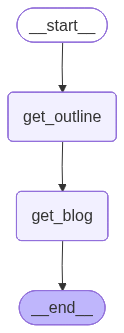

In [10]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())